In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import zed

# Connect to the default lake at http://localhost:9867
client = zed.Client()

# Define the file name
file_name = 'second_cap.pcapng'

# Define the Zed query
ZQL_query = '_path=="conn" | cut id.orig_h, id.orig_p, id.resp_h, id.resp_p, proto | sort id.orig_h, id.resp_h'

# Execute the Zed query on the file directly
values = client.query(f'from {file_name} | {ZQL_query}')

# Convert the iterator to a list and then create a dataframe, flattening the JSON/dictionary structure
data_frame = pd.json_normalize(list(values))

# CHECK FOR THE DATA IN DATA_FRAME:

In [2]:
#number of records (rows) that data_frame contains
print(len(data_frame))

44


In [3]:
# Display the first 5 rows of the DataFrame
data_frame.head(10)

,proto,id.orig_h,id.orig_p,id.resp_h,id.resp_p
0,udp,192.168.1.1,40703,239.255.255.250,1900
1,udp,192.168.1.134,5353,224.0.0.251,5353
2,udp,192.168.1.191,5353,224.0.0.251,5353
3,tcp,192.168.1.219,50166,3.223.248.73,443
4,tcp,192.168.1.219,50209,23.212.249.76,443
5,tcp,192.168.1.219,50208,23.212.249.76,443
6,tcp,192.168.1.219,49981,23.212.249.76,443
7,tcp,192.168.1.219,64994,31.13.66.2,443
8,tcp,192.168.1.219,65451,31.13.66.2,443
9,tcp,192.168.1.219,49180,31.13.66.2,443


In [4]:
#Which column and data types are in Dataframe?
data_frame.dtypes

proto        object
id.orig_h    object
id.orig_p     int64
id.resp_h    object
id.resp_p     int64
dtype: object

# Check empty field guide:
>Explanation of isna().sum();
> 1. df.isna() creates a boolean DataFrame where True indicates missing values;
> 2. df.isna().sum() computes the sum of True values for each column (axis 0 by default), effectively counting the number of missing values in each column.

In [5]:
#Check there is no emtpy field:
data_frame.isna().sum()

proto        0
id.orig_h    0
id.orig_p    0
id.resp_h    0
id.resp_p    0
dtype: int64

# DataFrame.dropna() guide:
Remove missing values from a DataFrame.

Parameters:
> axis: Determines whether rows (0 or 'index') or columns (1 or 'columns') containing missing values are removed.
0 or 'index': Drop rows which contain missing values.
1 or 'columns': Drop columns which contain missing values.

> how: Determines under what conditions rows or columns are removed from the DataFrame.
'any' (default): Drop the row or column if any NA values are present.
'all': Drop the row or column only if all values are NA.

> inplace: Whether to modify the DataFrame in place (True) or create a new one (False, default).
True to modify the DataFrame itself.
False to create a new DataFrame with missing values removed.


In [6]:
#If there is any empty cell, drop them:
data_frame.dropna(axis=0, how='any', inplace=True)

# Count number of distinct elements in a specific axis:

**DataFrame.nunique(axis=0, dropna=True)**  
Count number of distinct elements in specified axis.

- **axis**:  
  {0 or ‘index’, 1 or ‘columns’}, default 0  
  The axis to use. 0 or ‘index’ for row-wise, 1 or ‘columns’ for column-wise.

- **dropna**:  
  bool, default True  
  Don’t include NaN in the counts.


In [7]:
#check number of distinct host in id.orig_h col:
data_frame['id.orig_h'].nunique()

9

In [8]:
data_frame.describe()

,id.orig_p,id.resp_p
count,44.000000,44.000000
mean,41250.522727,1989.272727
std,21101.921502,3608.480273
min,8.000000,0.000000
25%,47060.750000,443.000000
50%,50195.500000,443.000000
75%,50706.750000,948.250000
max,65451.000000,19900.000000


# Returns a graph from Pandas DataFrame containing an edge list: 
## from_pandas_edgelist:
- Returns a graph from Pandas DataFrame containing an edge list.
- (df, source='source', target='target', edge_attr=None, create_using=None, edge_key=None)



In [9]:
#create the graph denotes the connections between hosts using networkx:
graph = nx.from_pandas_edgelist(data_frame, source='id.orig_h', target='id.resp_h', edge_attr=True, create_using=None, edge_key=None)

In [10]:
#number of nodes:
graph.number_of_nodes()

33

In [11]:
#number of edges:
graph.number_of_edges()

31

In [12]:
#how many degrees?
graph.degree()

DegreeView({IPv4Address('192.168.1.1'): 2, IPv4Address('239.255.255.250'): 1, IPv4Address('192.168.1.134'): 2, IPv4Address('224.0.0.251'): 3, IPv4Address('192.168.1.191'): 1, IPv4Address('192.168.1.219'): 24, IPv4Address('3.223.248.73'): 1, IPv4Address('23.212.249.76'): 1, IPv4Address('31.13.66.2'): 1, IPv4Address('31.13.66.4'): 1, IPv4Address('31.13.66.49'): 1, IPv4Address('52.159.49.199'): 1, IPv4Address('52.160.90.77'): 1, IPv4Address('52.182.143.208'): 1, IPv4Address('64.233.180.95'): 1, IPv4Address('66.254.114.41'): 1, IPv4Address('104.16.115.50'): 1, IPv4Address('104.16.116.50'): 1, IPv4Address('108.156.184.88'): 1, IPv4Address('122.11.128.50'): 1, IPv4Address('142.251.111.190'): 1, IPv4Address('162.159.130.234'): 1, IPv4Address('162.247.241.2'): 1, IPv4Address('172.168.11.34'): 1, IPv4Address('172.253.115.95'): 1, IPv4Address('192.168.1.145'): 1, IPv4Address('203.118.6.134'): 1, IPv6Address('fe80::2e64:1fff:feef:9f31'): 1, IPv6Address('ff02::fb'): 3, IPv6Address('fe80::87cd:2c64

In [13]:
#check if the graph is directed:
graph.is_directed()

False

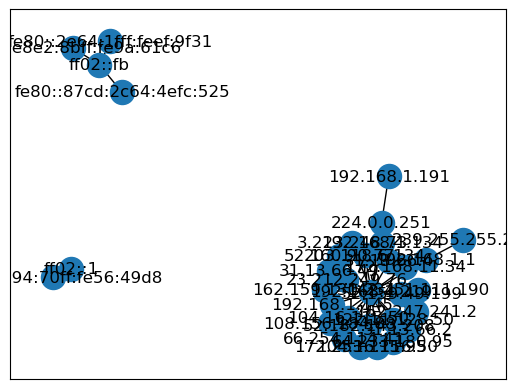

In [14]:
#draw network graph:
nx.draw_networkx(graph)